# Slides for 2018-07-27 Meeting

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import fisher_exact

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import gffutils

# Project level imports
from larval_gonad.config import read_config
from larval_gonad.notebook import Nb
from larval_gonad.scRNAseq import fe_tsne, raw_data, norm_data
from larval_gonad.normalization import tpm, rpkm, zscore

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force/')

last updated: 2018-08-02 
Git hash: 3dea10cf21d9202ae5f93538e502df039f150f49


In [3]:
cmapper = {nbconfig.CLUSTER_ANNOT[k]: v for k, v in zip(nbconfig.CLUSTER_ANNOT, nbconfig.colors['clusters'])}
font = {'size': 12, 'weight': 'bold'}

def add_labels(ax):
    pos = 0.04
    for clus in nbconfig.CLUSTER_ORDER:
        ax.plot(pos, 1, 'bo', markersize=5, color=cmapper[clus])
        pos += 0.084
        sns.despine(ax=ax, left=True, bottom=True)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [4]:
plt.rcParams['figure.dpi'] = 300

## Figure 1

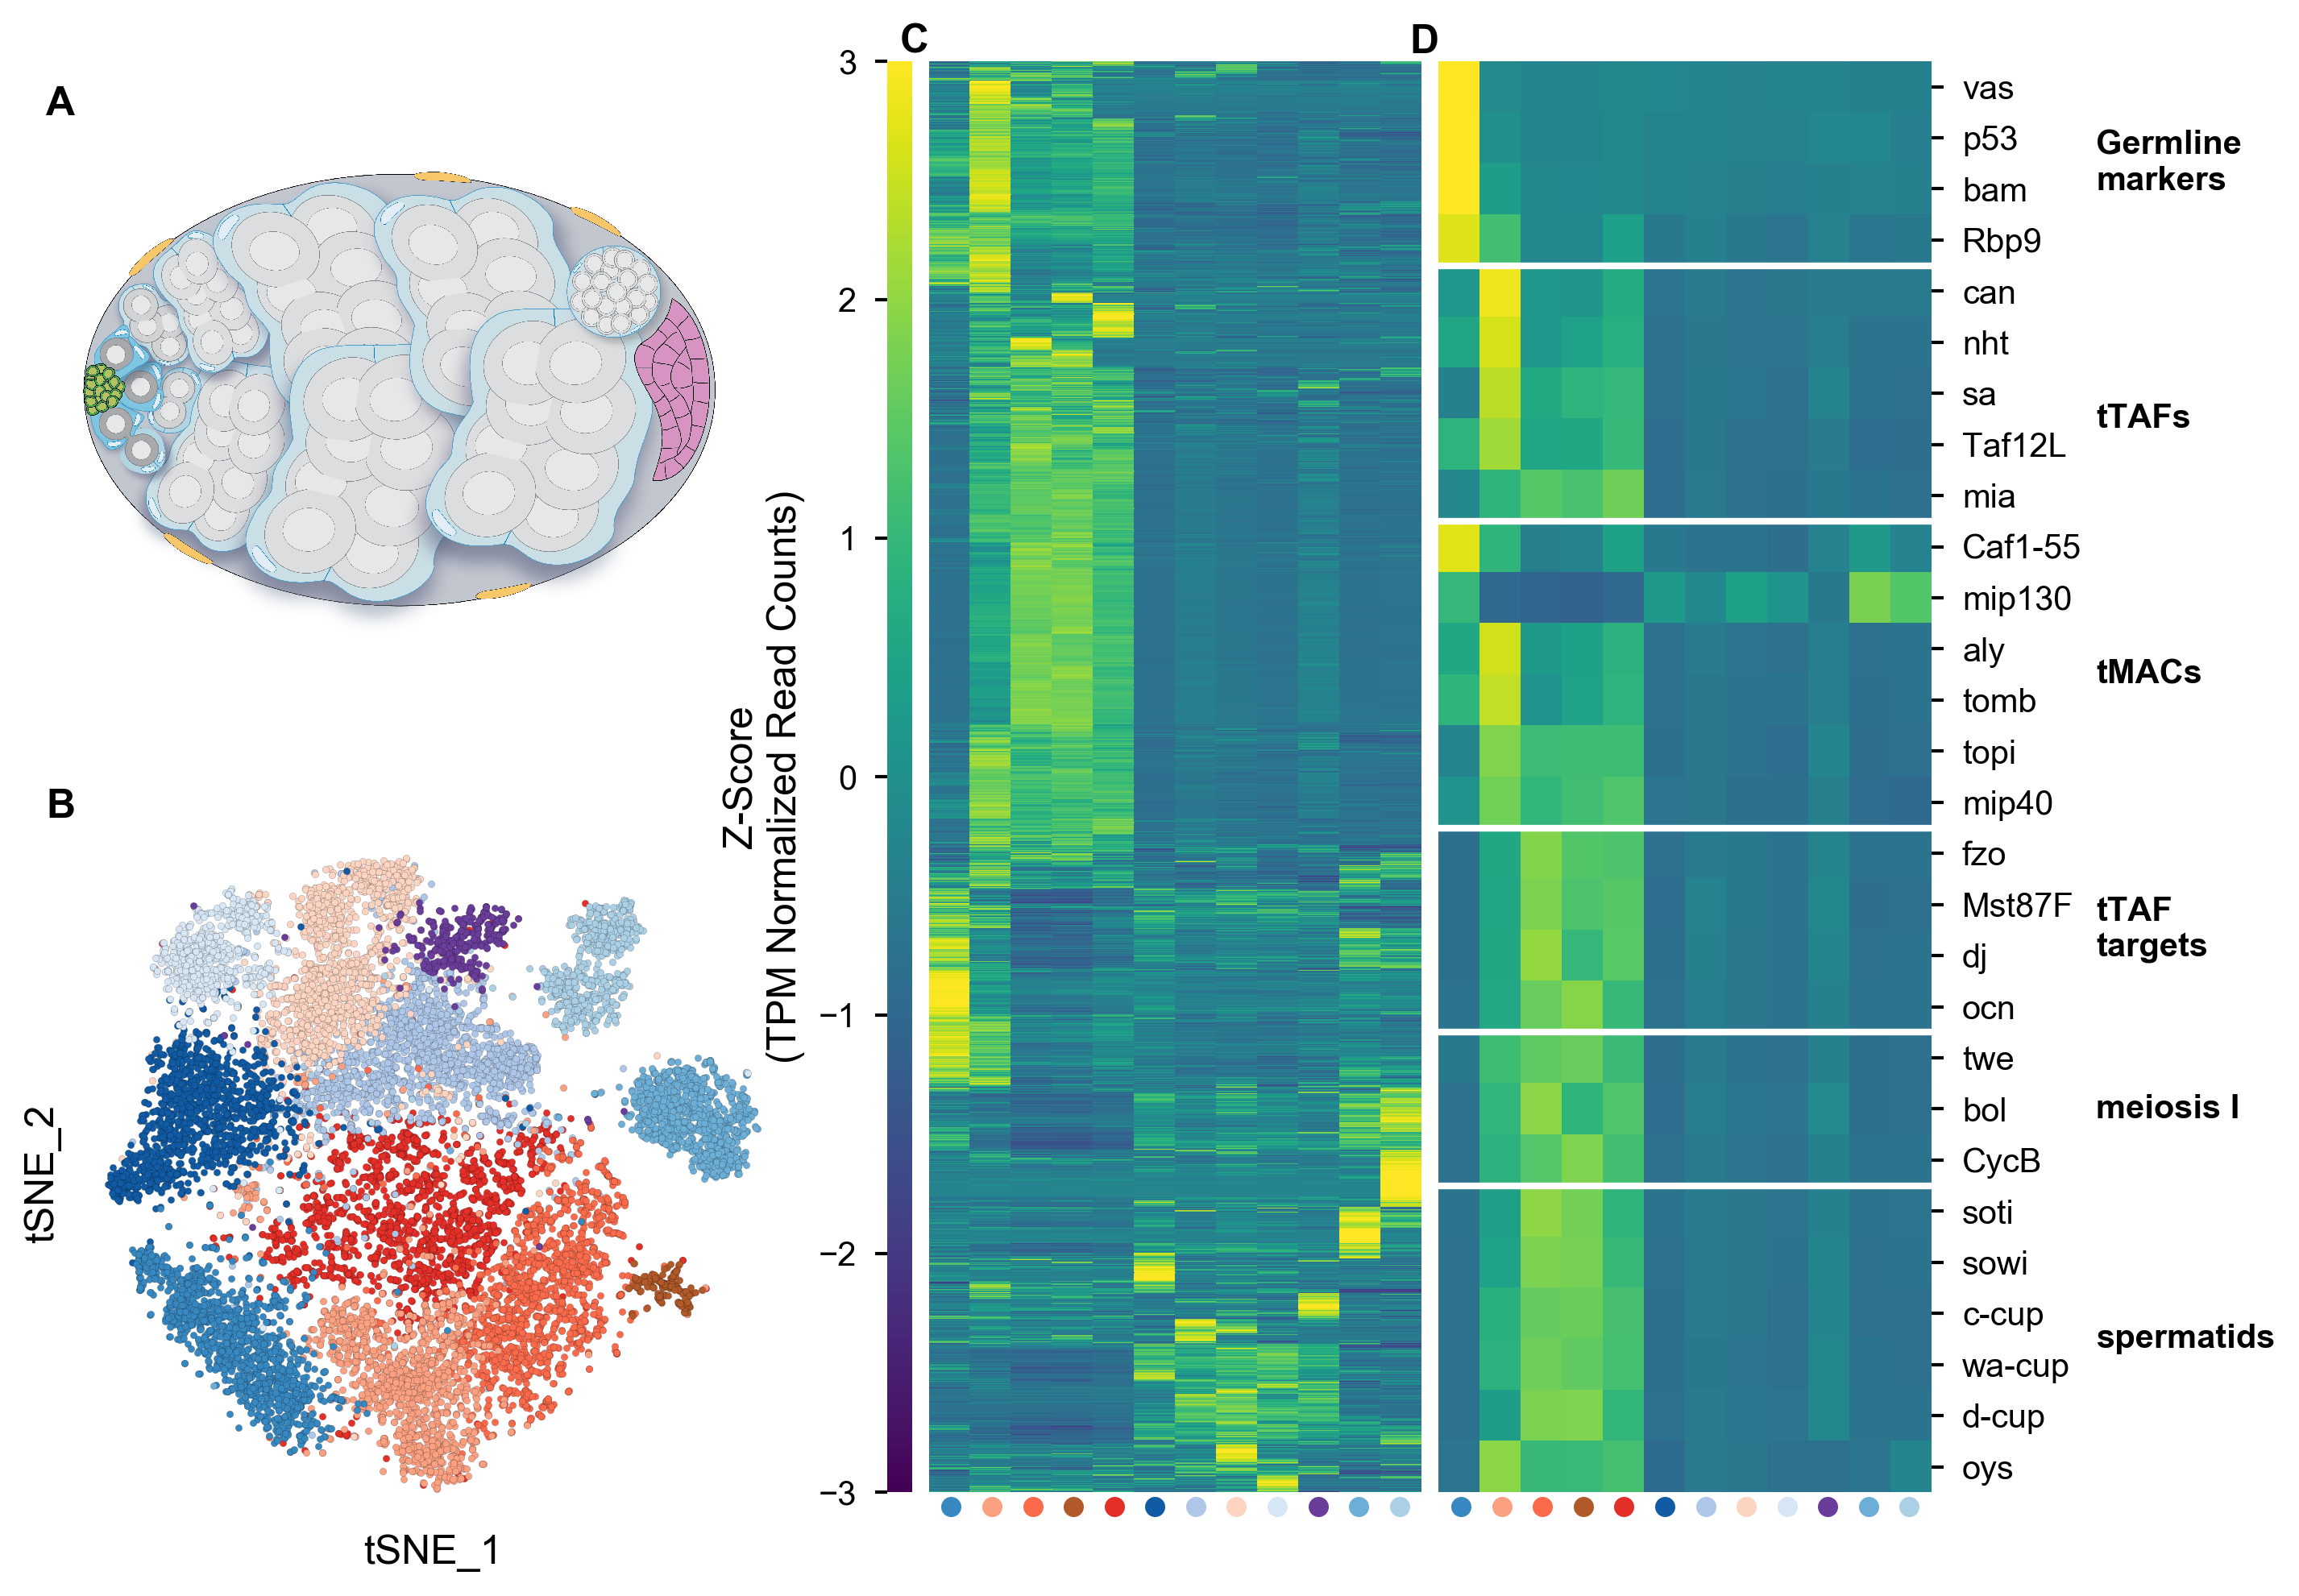

In [6]:
fig = plt.figure(figsize=(8, 8))

gs1 = plt.GridSpec(2, 1, 
                   wspace=.05, hspace=.1, 
                   left=0.03, right=0.4,
                  )

gs2 = plt.GridSpec(2, 3, 
                   wspace=0.05, hspace=0, 
                   left=0.45, right=0.99, 
                   height_ratios=[1, .02], width_ratios=[.05, 1, 1], 
                  )

axDia = plt.subplot(gs1[0, 0])
axTsne = plt.subplot(gs1[1, 0])

axAll = plt.subplot(gs2[0, 1])
axAllLabel = plt.subplot(gs2[1, 1])
axLit = plt.subplot(gs2[0, 2])
axLitLabel = plt.subplot(gs2[1, 2])
axCBar = plt.subplot(gs2[0, 0])

# Add figure labels
plt.text(0, 1, 'A', transform=axDia.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'B', transform=axTsne.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'C', transform=axAll.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'D', transform=axLit.transAxes, fontdict=font, va='bottom', ha='right')

# Add color labels to heatmaps
add_labels(axAllLabel)
add_labels(axLitLabel)


# Diagram (A)
img = plt.imread('../data/external/larval_testis_diagram.png')
axDia.imshow(img, interpolation='nearest')
axDia.xaxis.set_visible(False)
axDia.yaxis.set_visible(False)
sns.despine(ax=axDia, left=True, bottom=True)

# TSNE (B)
fe_tsne(seurat_dir=nbconfig.seurat_dir, ax=axTsne, s=4)
axTsne.legend_.remove()
sns.despine(ax=axTsne, left=True, bottom=True)

# Heatmap All Genes (C)
_tpm = pd.read_parquet('../output/scrnaseq-wf/tpm.parquet')
_zscore = zscore(_tpm[nbconfig.CLUSTER_ORDER])

link = linkage(_zscore.values, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

sns.heatmap(_zscore.iloc[leaves], cmap='viridis', 
            yticklabels=False, xticklabels=False, 
            cbar_ax=axCBar, vmin=-3, vmax=3, ax=axAll)
axAll.set_ylabel('')
axCBar.yaxis.tick_left()
axCBar.set_ylabel('Z-Score\n(TPM Normalized Read Counts)')
axCBar.yaxis.set_label_position('left')

# Heatmap Literature Genes (D)
lit_genes = [nbconfig.symbol2fbgn[x] for x in read_config('../paper_submission/config.yaml')['lit_genes']]
## Genes for plot
go = [
    # Gonia
    'vas',
    'p53',
    'bam',
    'Rbp9',
    
    # Later spermatocytes
    ## tTAFs
    'can',
    'nht',
    'sa',
    'Taf12L',
    'mia',
    
    # tMAC
    'Caf1-55',
    'mip130',
    'aly',
    'tomb',
    'topi',
    'mip40',
    
    # terminal differentiation genes
    'fzo',
    'Mst87F',
    'dj',
    'ocn',
    
    # required for meiosis I
    'twe',
    'bol',
    'CycB',
    
    # Important for spermatid
    'soti',
    'sowi',
    'c-cup',
    'wa-cup',
    'd-cup',
    'oys',
]

lit_genes = [nbconfig.symbol2fbgn[x] for x in go]

_zlit = _zscore[_zscore.index.isin(lit_genes)]
_zlit.index = _zlit.index.map(nbconfig.fbgn2symbol)

link = linkage(_zlit.values, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

axLit.yaxis.set_label_position('right')
#sns.heatmap(_zlit.iloc[leaves], cmap='viridis', yticklabels=True, xticklabels=False, cbar=False, vmin=-3, vmax=3, ax=axLit)
sns.heatmap(_zlit.loc[go], cmap='viridis', yticklabels=True, xticklabels=False, cbar=False, vmin=-3, vmax=3, ax=axLit)
axLit.yaxis.tick_right()
axLit.set_ylabel('')
plt.setp(axLit.get_yticklabels(), rotation=0, fontsize=10);

axLit.axhline(4, color='w', lw=2)
axLit.axhline(9, color='w', lw=2)
axLit.axhline(15, color='w', lw=2)
axLit.axhline(19, color='w', lw=2)
axLit.axhline(22, color='w', lw=2)

axLit.text(16, 2, 'Germline\nmarkers', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 7, 'tTAFs', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 12, 'tMACs', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 17, 'tTAF\ntargets', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 20.5, 'meiosis I', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 25, 'spermatids', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'});

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

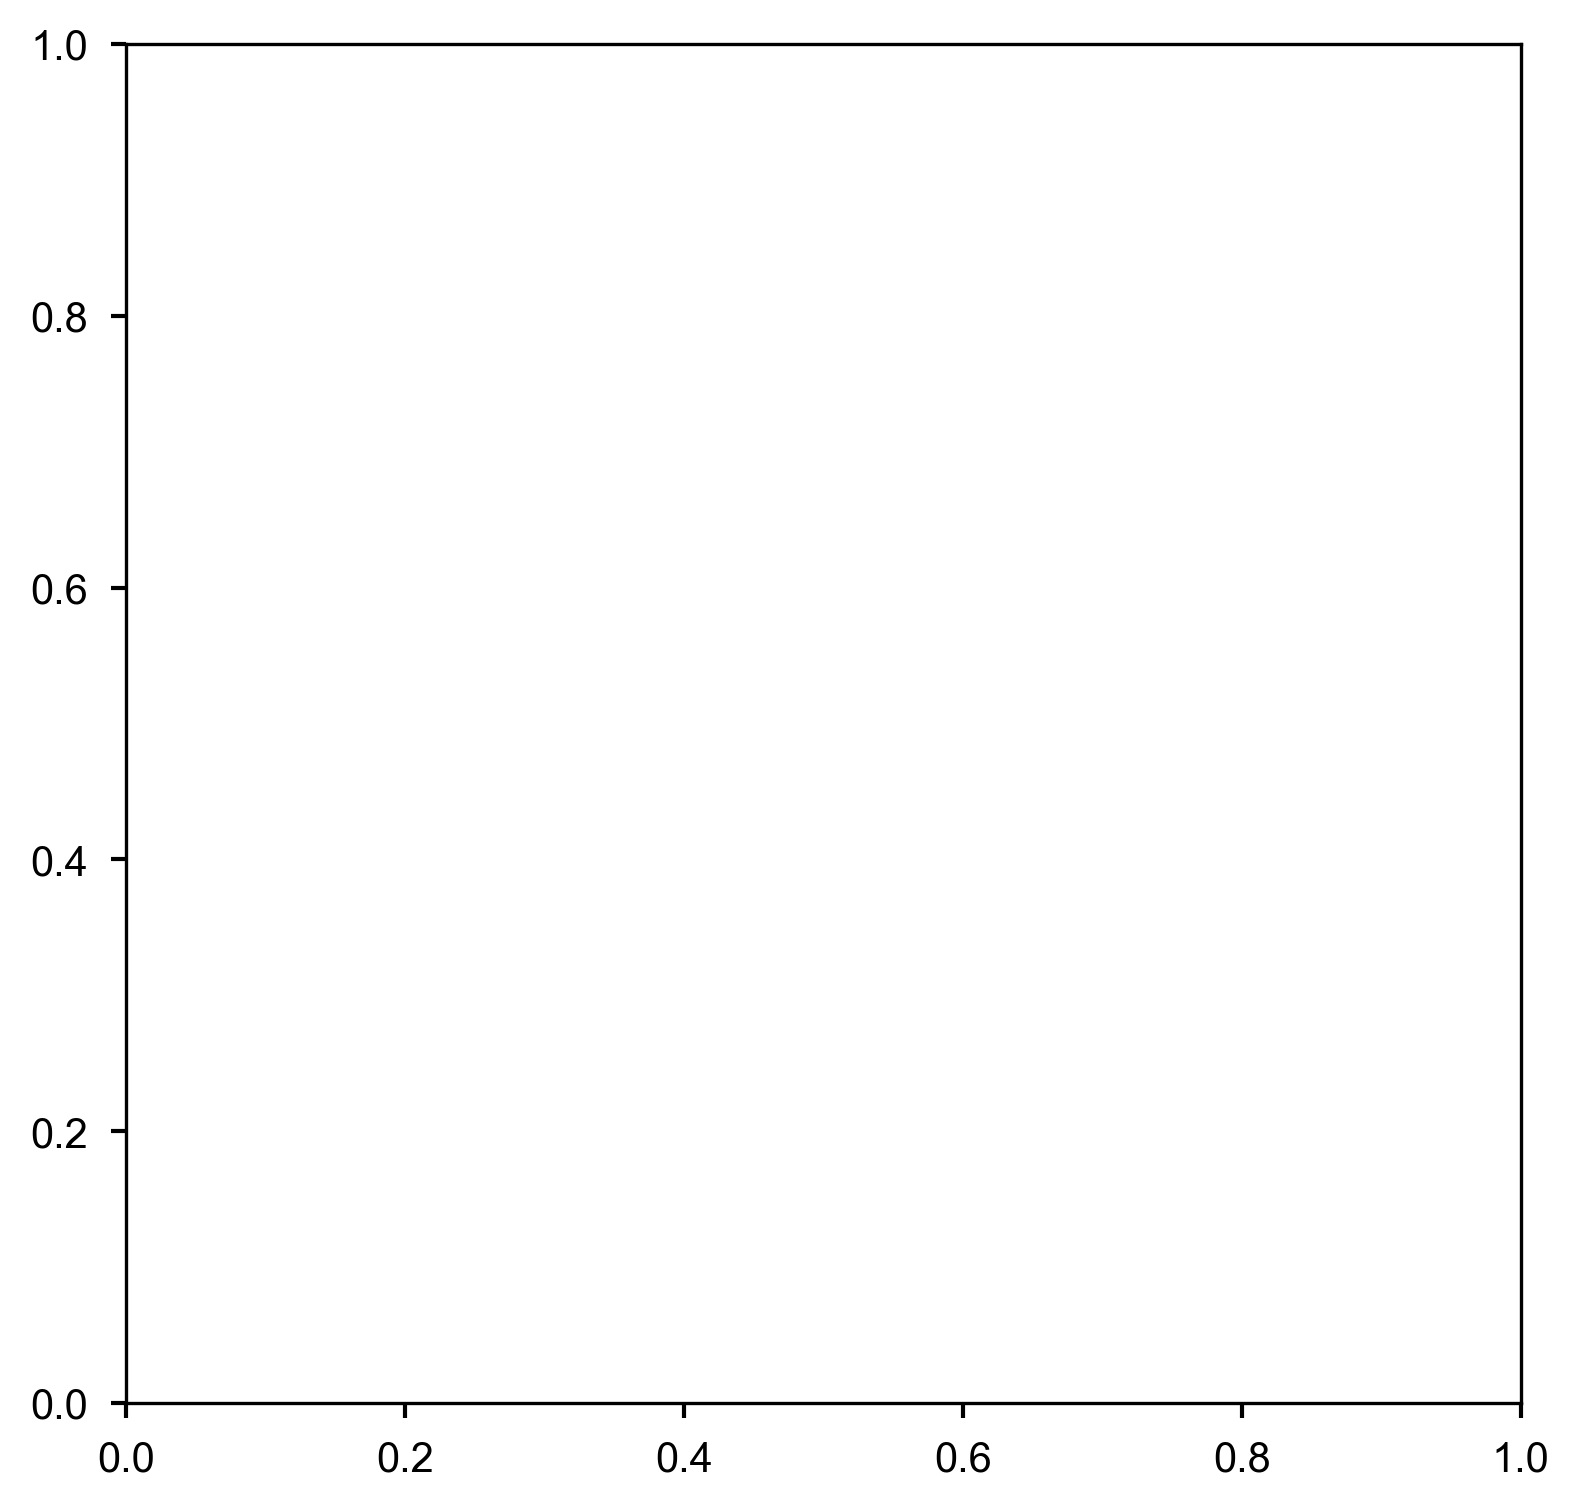

In [54]:
fig, ax = plt.subplots()
plt.colorbar(cax=ax)

In [32]:
cmap = dict(zip(nbconfig.CLUSTER_ORDER, nbconfig.colors['clusters']))

In [36]:
nbconfig.colors['clusters']

[(0.8901960784313725, 0.18562091503267975, 0.15294117647058825),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (0.9843752402921953, 0.4181468665897732, 0.2926566705113418),
 (0.9882352941176471, 0.6261437908496732, 0.5084967320261438),
 (0.9935870818915802, 0.8323414071510957, 0.7624913494809689),
 (0.06251441753171857, 0.35750865051903113, 0.6429065743944637),
 (0.21568627450980393, 0.5294117647058824, 0.7542483660130719),
 (0.42274509803921567, 0.684075355632449, 0.8398923490965013),
 (0.6718954248366014, 0.8143790849673203, 0.9006535947712418),
 (0.8406920415224913, 0.9016378316032295, 0.9586620530565167),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [10]:
dat = tsne.join(nbconfig.seurat.get_clusters('res.0.6'))

In [14]:
dat.cluster.replace(nbconfig.CLUSTER_ANNOT, inplace=True)

In [30]:
colormap = mpl.cm.Dark2.colors   # Qualitative colormap

In [31]:
colormap

((0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4))

In [49]:
c = dat['cluster'].map(lambda x: cmap[x])

In [50]:
c

FBgn
rep1_AAACCTGAGACAAGCC    (0.21568627450980393, 0.5294117647058824, 0.75...
rep1_AAACCTGAGCTTATCG    (0.21568627450980393, 0.5294117647058824, 0.75...
rep1_AAACCTGGTGTAATGA    (0.06251441753171857, 0.35750865051903113, 0.6...
rep1_AAACCTGGTTCATGGT    (0.9843752402921953, 0.4181468665897732, 0.292...
rep1_AAACCTGTCCCTCTTT    (0.21568627450980393, 0.5294117647058824, 0.75...
rep1_AAACGGGAGACTGGGT    (0.42274509803921567, 0.684075355632449, 0.839...
rep1_AAACGGGCACAGTCGC    (0.9935870818915802, 0.8323414071510957, 0.762...
rep1_AAACGGGGTCGCGTGT    (0.9935870818915802, 0.8323414071510957, 0.762...
rep1_AAACGGGGTGTTAAGA    (0.06251441753171857, 0.35750865051903113, 0.6...
rep1_AAACGGGTCGTCCAGG    (0.21568627450980393, 0.5294117647058824, 0.75...
rep1_AAACGGGTCTTGTATC    (0.21568627450980393, 0.5294117647058824, 0.75...
rep1_AAAGATGAGCGCCTCA    (0.8406920415224913, 0.9016378316032295, 0.958...
rep1_AAAGATGAGTATCGAA    (0.42274509803921567, 0.684075355632449, 0.839...
rep1_AAAGATGAGTGGTAG

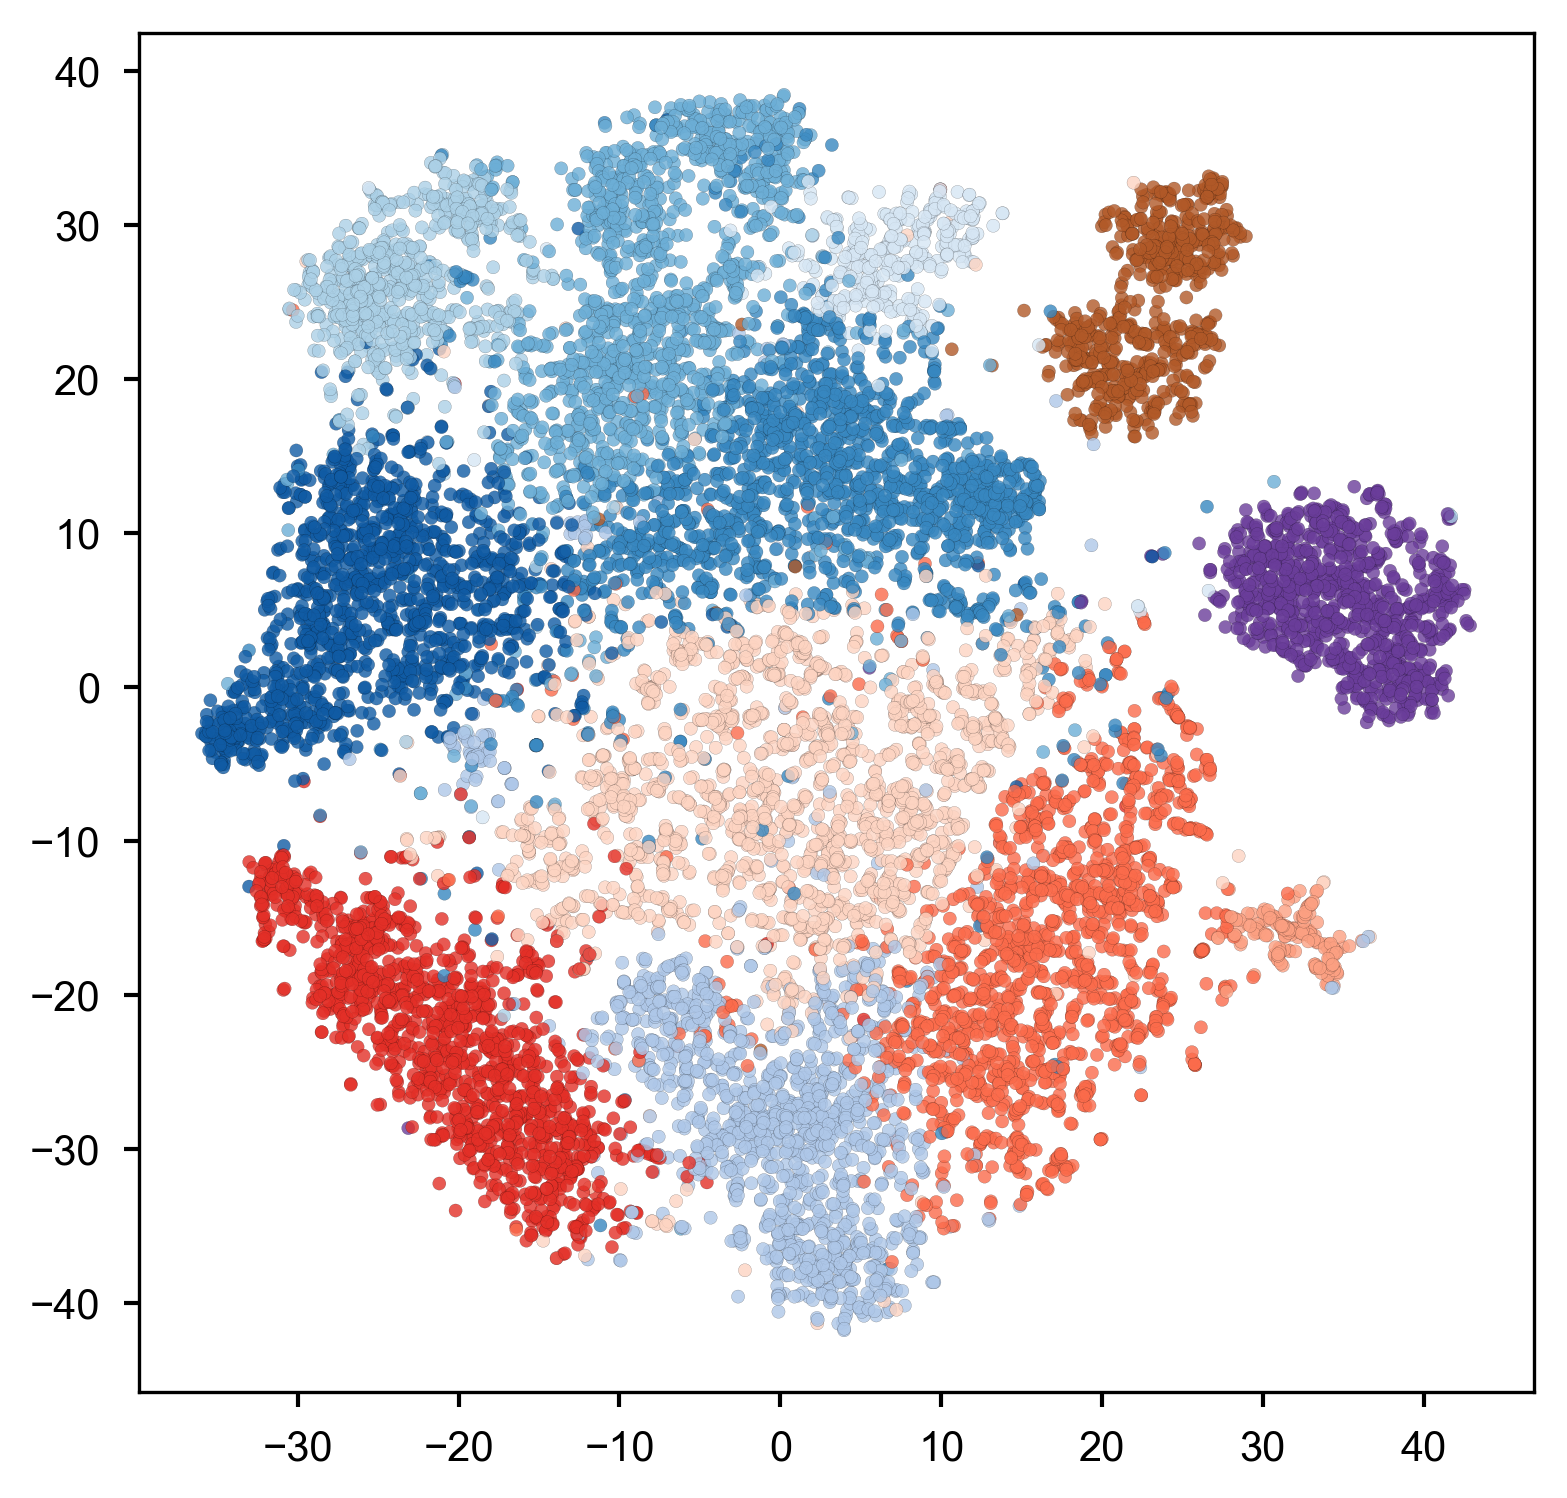

In [51]:
plt.scatter(dat['tSNE_1'], dat['tSNE_2'], c=c, s=10, edgecolor='k', alpha=.8)

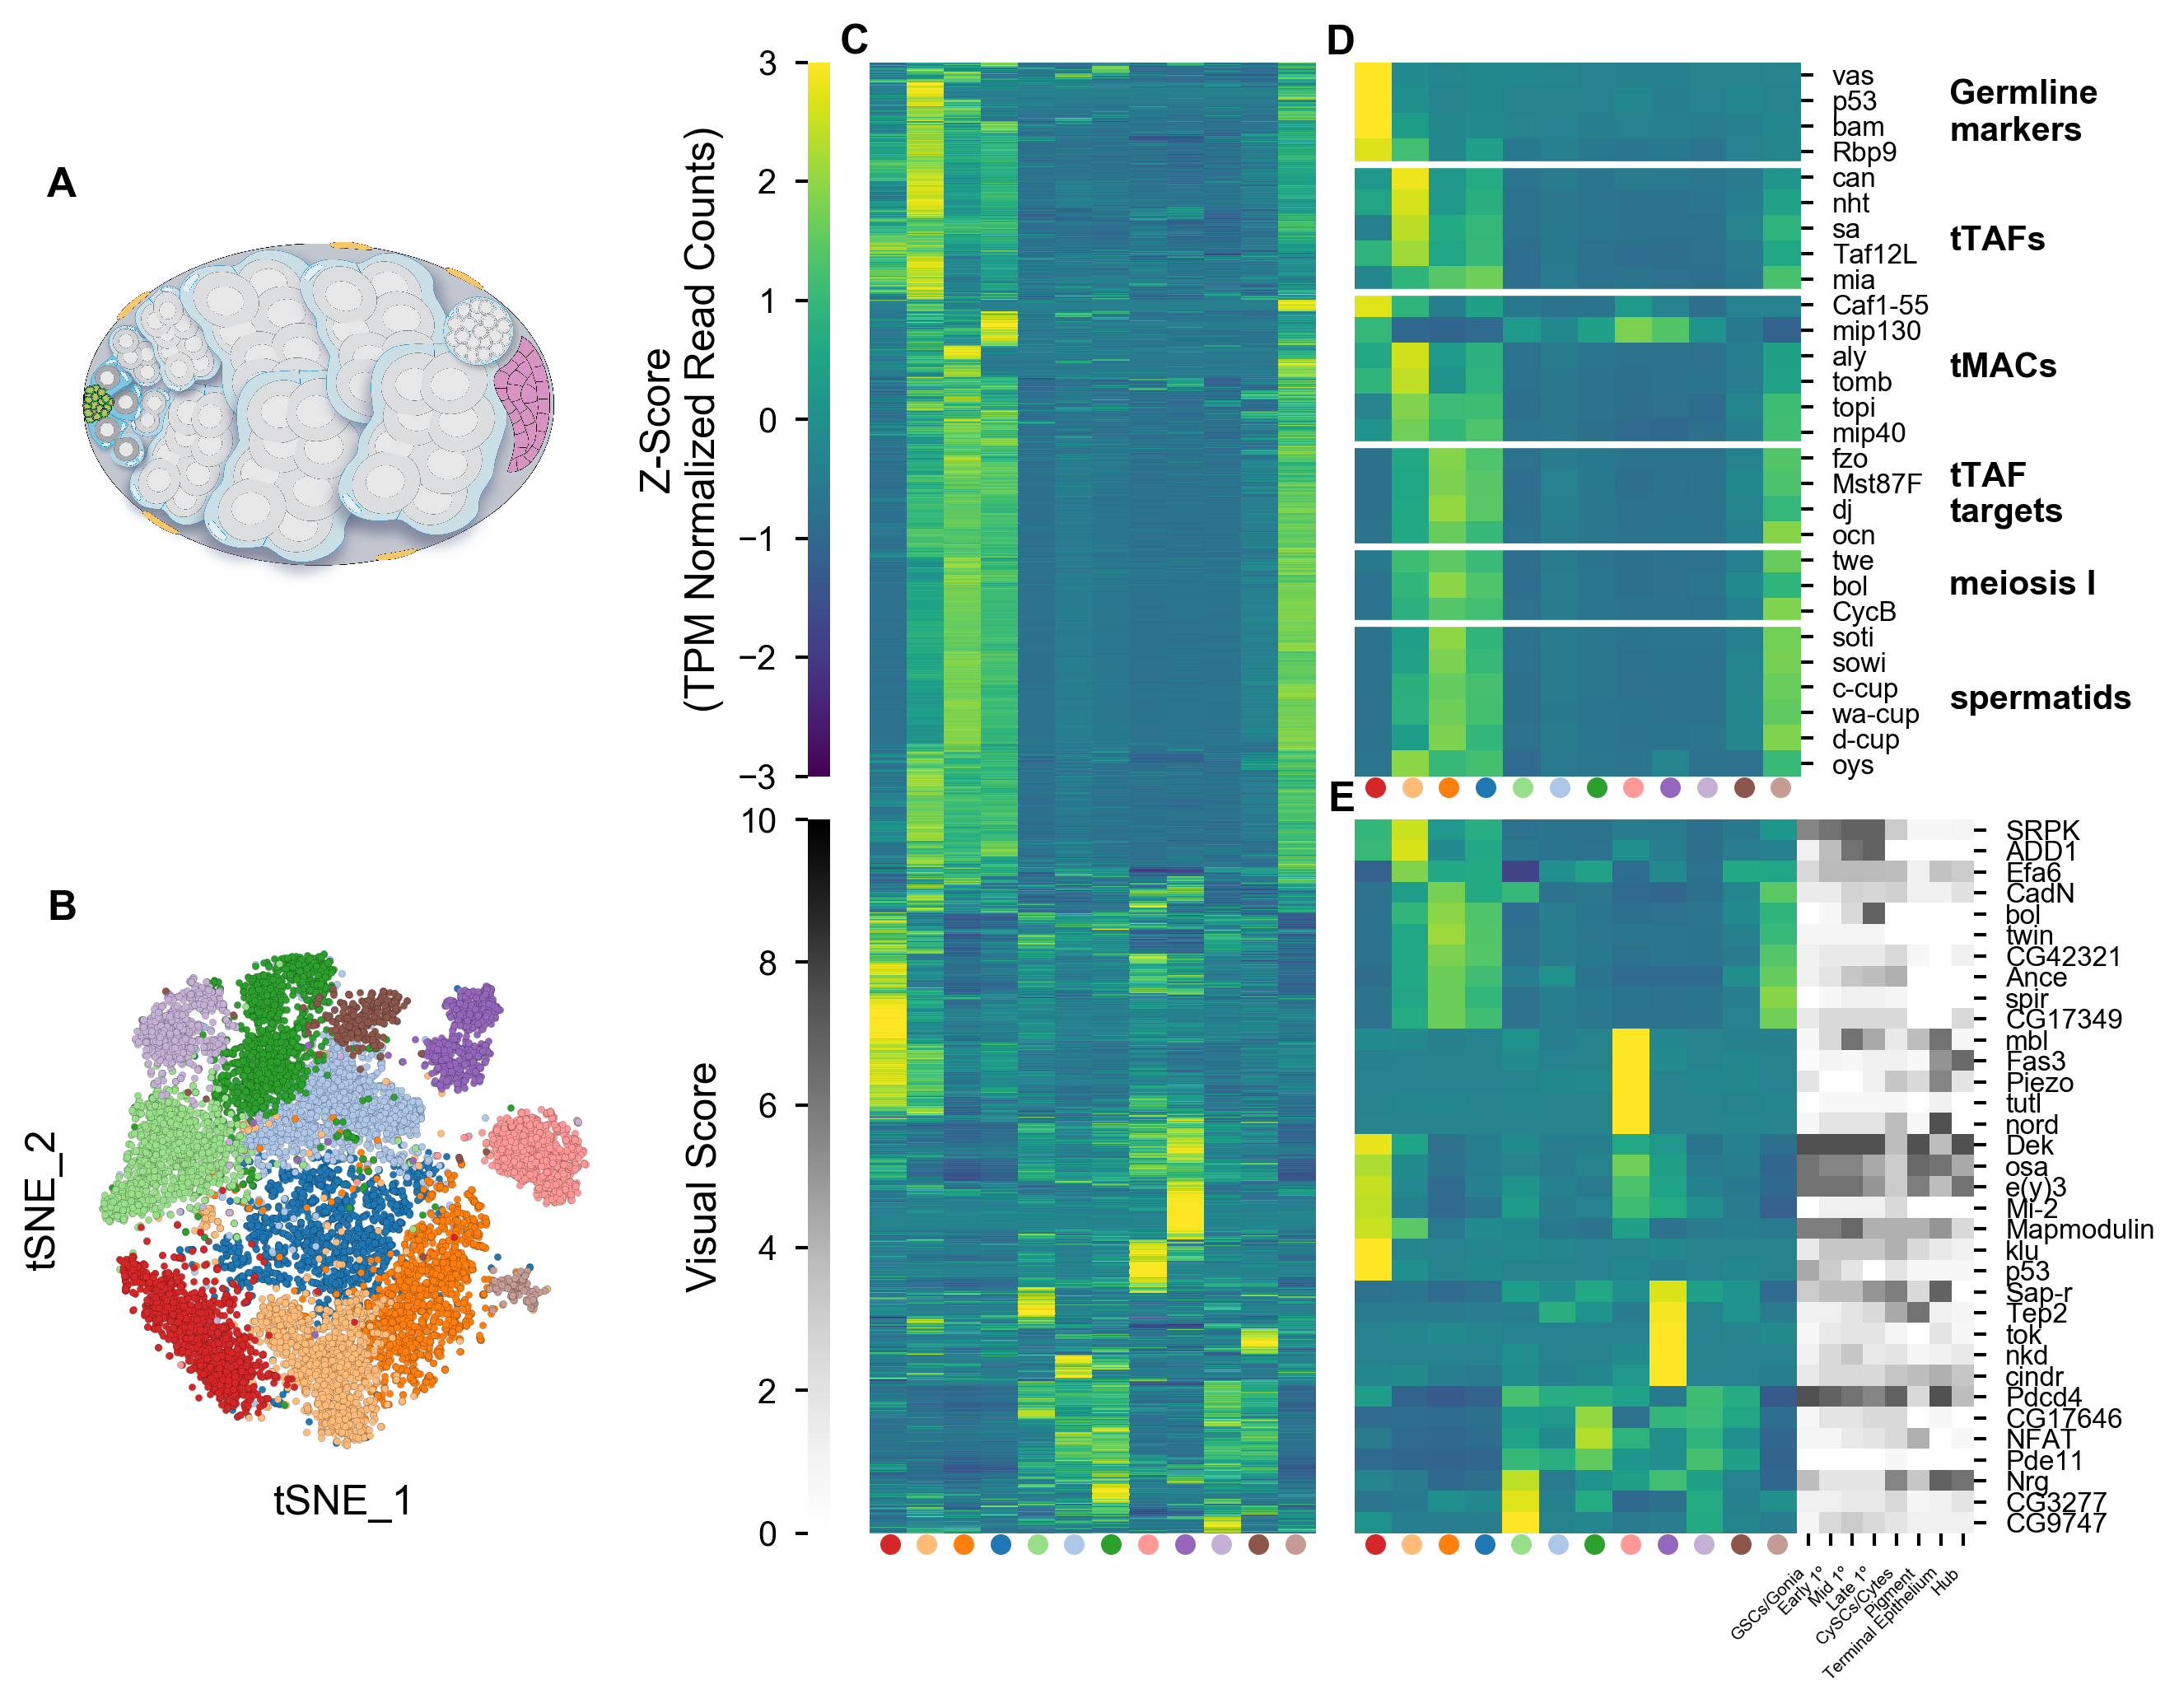

In [54]:
fig = plt.figure(figsize=(8, 8))

gs1 = plt.GridSpec(2, 1, 
                   wspace=.05, hspace=.1, 
                   left=0.03, right=0.30,
                  )

gs2 = plt.GridSpec(5, 4, 
                   wspace=0.15, hspace=0, 
                   left=0.4, right=0.99, 
                   height_ratios=[1, .03, .03, 1, .03], width_ratios=[.05, 1, 1, .3], 
                  )


axDia = plt.subplot(gs1[0, 0])
axTsne = plt.subplot(gs1[1, 0])

axCBar1 = plt.subplot(gs2[0, 0])
axCBar2 = plt.subplot(gs2[3, 0])

axAll = plt.subplot(gs2[0:4, 1])
axAllLabel = plt.subplot(gs2[4, 1])

axLit = plt.subplot(gs2[0, 2])
axLitLabel = plt.subplot(gs2[1, 2])

gsPtrap = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs2[3:, 2:], wspace=0, hspace=0, width_ratios=[1, .4], height_ratios=[1, .03])
axPtrap = plt.subplot(gsPtrap[0, 0])
axScore = plt.subplot(gsPtrap[0, 1])
axPtrapLabel = plt.subplot(gsPtrap[1, 0])


# Add figure labels
plt.text(0, 1, 'A', transform=axDia.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'B', transform=axTsne.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'C', transform=axAll.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'D', transform=axLit.transAxes, fontdict=font, va='bottom', ha='right')
plt.text(0, 1, 'E', transform=axPtrap.transAxes, fontdict=font, va='bottom', ha='right')

# Add color labels to heatmaps
add_labels(axAllLabel)
add_labels(axLitLabel)
add_labels(axPtrapLabel)

# Diagram (A)
img = plt.imread('../data/external/larval_testis_diagram.png')
axDia.imshow(img, interpolation='nearest')
axDia.xaxis.set_visible(False)
axDia.yaxis.set_visible(False)
sns.despine(ax=axDia, left=True, bottom=True)

# TSNE (B)
fe_tsne(seurat_dir=nbconfig.seurat_dir, ax=axTsne, s=4)
axTsne.legend_.remove()
axTsne.set_aspect('equal')
sns.despine(ax=axTsne, left=True, bottom=True)

# Heatmap All Genes (C)
_tpm = pd.read_parquet('../output/scrnaseq-wf/tpm.parquet')
_zscore = zscore(_tpm[nbconfig.CLUSTER_ORDER])

link = linkage(_zscore.values, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

sns.heatmap(_zscore.iloc[leaves], cmap='viridis', 
            yticklabels=False, xticklabels=False, 
            cbar_ax=axCBar1, vmin=-3, vmax=3, ax=axAll)
axAll.set_ylabel('')
axCBar1.yaxis.tick_left()
axCBar1.set_ylabel('Z-Score\n(TPM Normalized Read Counts)')
axCBar1.yaxis.set_label_position('left')

# Heatmap Literature Genes (D)
lit_genes = [nbconfig.symbol2fbgn[x] for x in read_config('../paper_submission/config.yaml')['lit_genes']]
## Genes for plot
go = [
    # Gonia
    'vas',
    'p53',
    'bam',
    'Rbp9',
    
    # Later spermatocytes
    ## tTAFs
    'can',
    'nht',
    'sa',
    'Taf12L',
    'mia',
    
    # tMAC
    'Caf1-55',
    'mip130',
    'aly',
    'tomb',
    'topi',
    'mip40',
    
    # terminal differentiation genes
    'fzo',
    'Mst87F',
    'dj',
    'ocn',
    
    # required for meiosis I
    'twe',
    'bol',
    'CycB',
    
    # Important for spermatid
    'soti',
    'sowi',
    'c-cup',
    'wa-cup',
    'd-cup',
    'oys',
]

lit_genes = [nbconfig.symbol2fbgn[x] for x in go]

_zlit = _zscore[_zscore.index.isin(lit_genes)]
_zlit.index = _zlit.index.map(nbconfig.fbgn2symbol)

link = linkage(_zlit.values, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

axLit.yaxis.set_label_position('right')
#sns.heatmap(_zlit.iloc[leaves], cmap='viridis', yticklabels=True, xticklabels=False, cbar=False, vmin=-3, vmax=3, ax=axLit)
sns.heatmap(_zlit.loc[go], cmap='viridis', yticklabels=True, xticklabels=False, cbar=False, vmin=-3, vmax=3, ax=axLit)
axLit.yaxis.tick_right()
axLit.set_ylabel('')
plt.setp(axLit.get_yticklabels(), rotation=0, fontsize=8);

axLit.axhline(4, color='w', lw=2)
axLit.axhline(9, color='w', lw=2)
axLit.axhline(15, color='w', lw=2)
axLit.axhline(19, color='w', lw=2)
axLit.axhline(22, color='w', lw=2)

axLit.text(16, 2, 'Germline\nmarkers', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 7, 'tTAFs', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 12, 'tMACs', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 17, 'tTAF\ntargets', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 20.5, 'meiosis I', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'})
axLit.text(16, 25, 'spermatids', va='center', ha='left', fontsize=10, fontdict={'weight': 'bold'});


# Heatmap PTrap Genes (E)
miriam = pd.read_csv('../data/external/2018-07-27_munge_miriam_.tsv', sep='\t', index_col=[0, 1])
miriam.index = miriam.index.droplevel(0)
miriam_genes = miriam.index.tolist()

_zp = _zscore.copy()
_zp.index = _zp.index.map(nbconfig.fbgn2symbol)
_zp = _zp.reindex(miriam_genes)

link = linkage(_zp.values, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

axPtrap.yaxis.set_label_position('right')
sns.heatmap(_zp.iloc[leaves], cmap='viridis', yticklabels=False, xticklabels=False, cbar=False, vmin=-3, vmax=3, ax=axPtrap)
axPtrap.yaxis.tick_right()
axPtrap.set_ylabel('')

sns.heatmap(miriam.iloc[leaves], ax=axScore, cmap='Greys', yticklabels=True, xticklabels=True, vmin=0, vmax=10, cbar_ax=axCBar2)
axScore.yaxis.set_ticks_position('right')
plt.setp(axScore.get_yticklabels(), rotation=0, fontsize=8);
plt.setp(axScore.get_xticklabels(), rotation=45, ha='right', fontsize=5);
axScore.set_ylabel('')

axCBar2.yaxis.tick_left()
axCBar2.set_ylabel('Visual Score')
axCBar2.yaxis.set_label_position('left')

## Figure 2

Germ cells show a decrease in X accumulation as the progress through spermatogenesis.

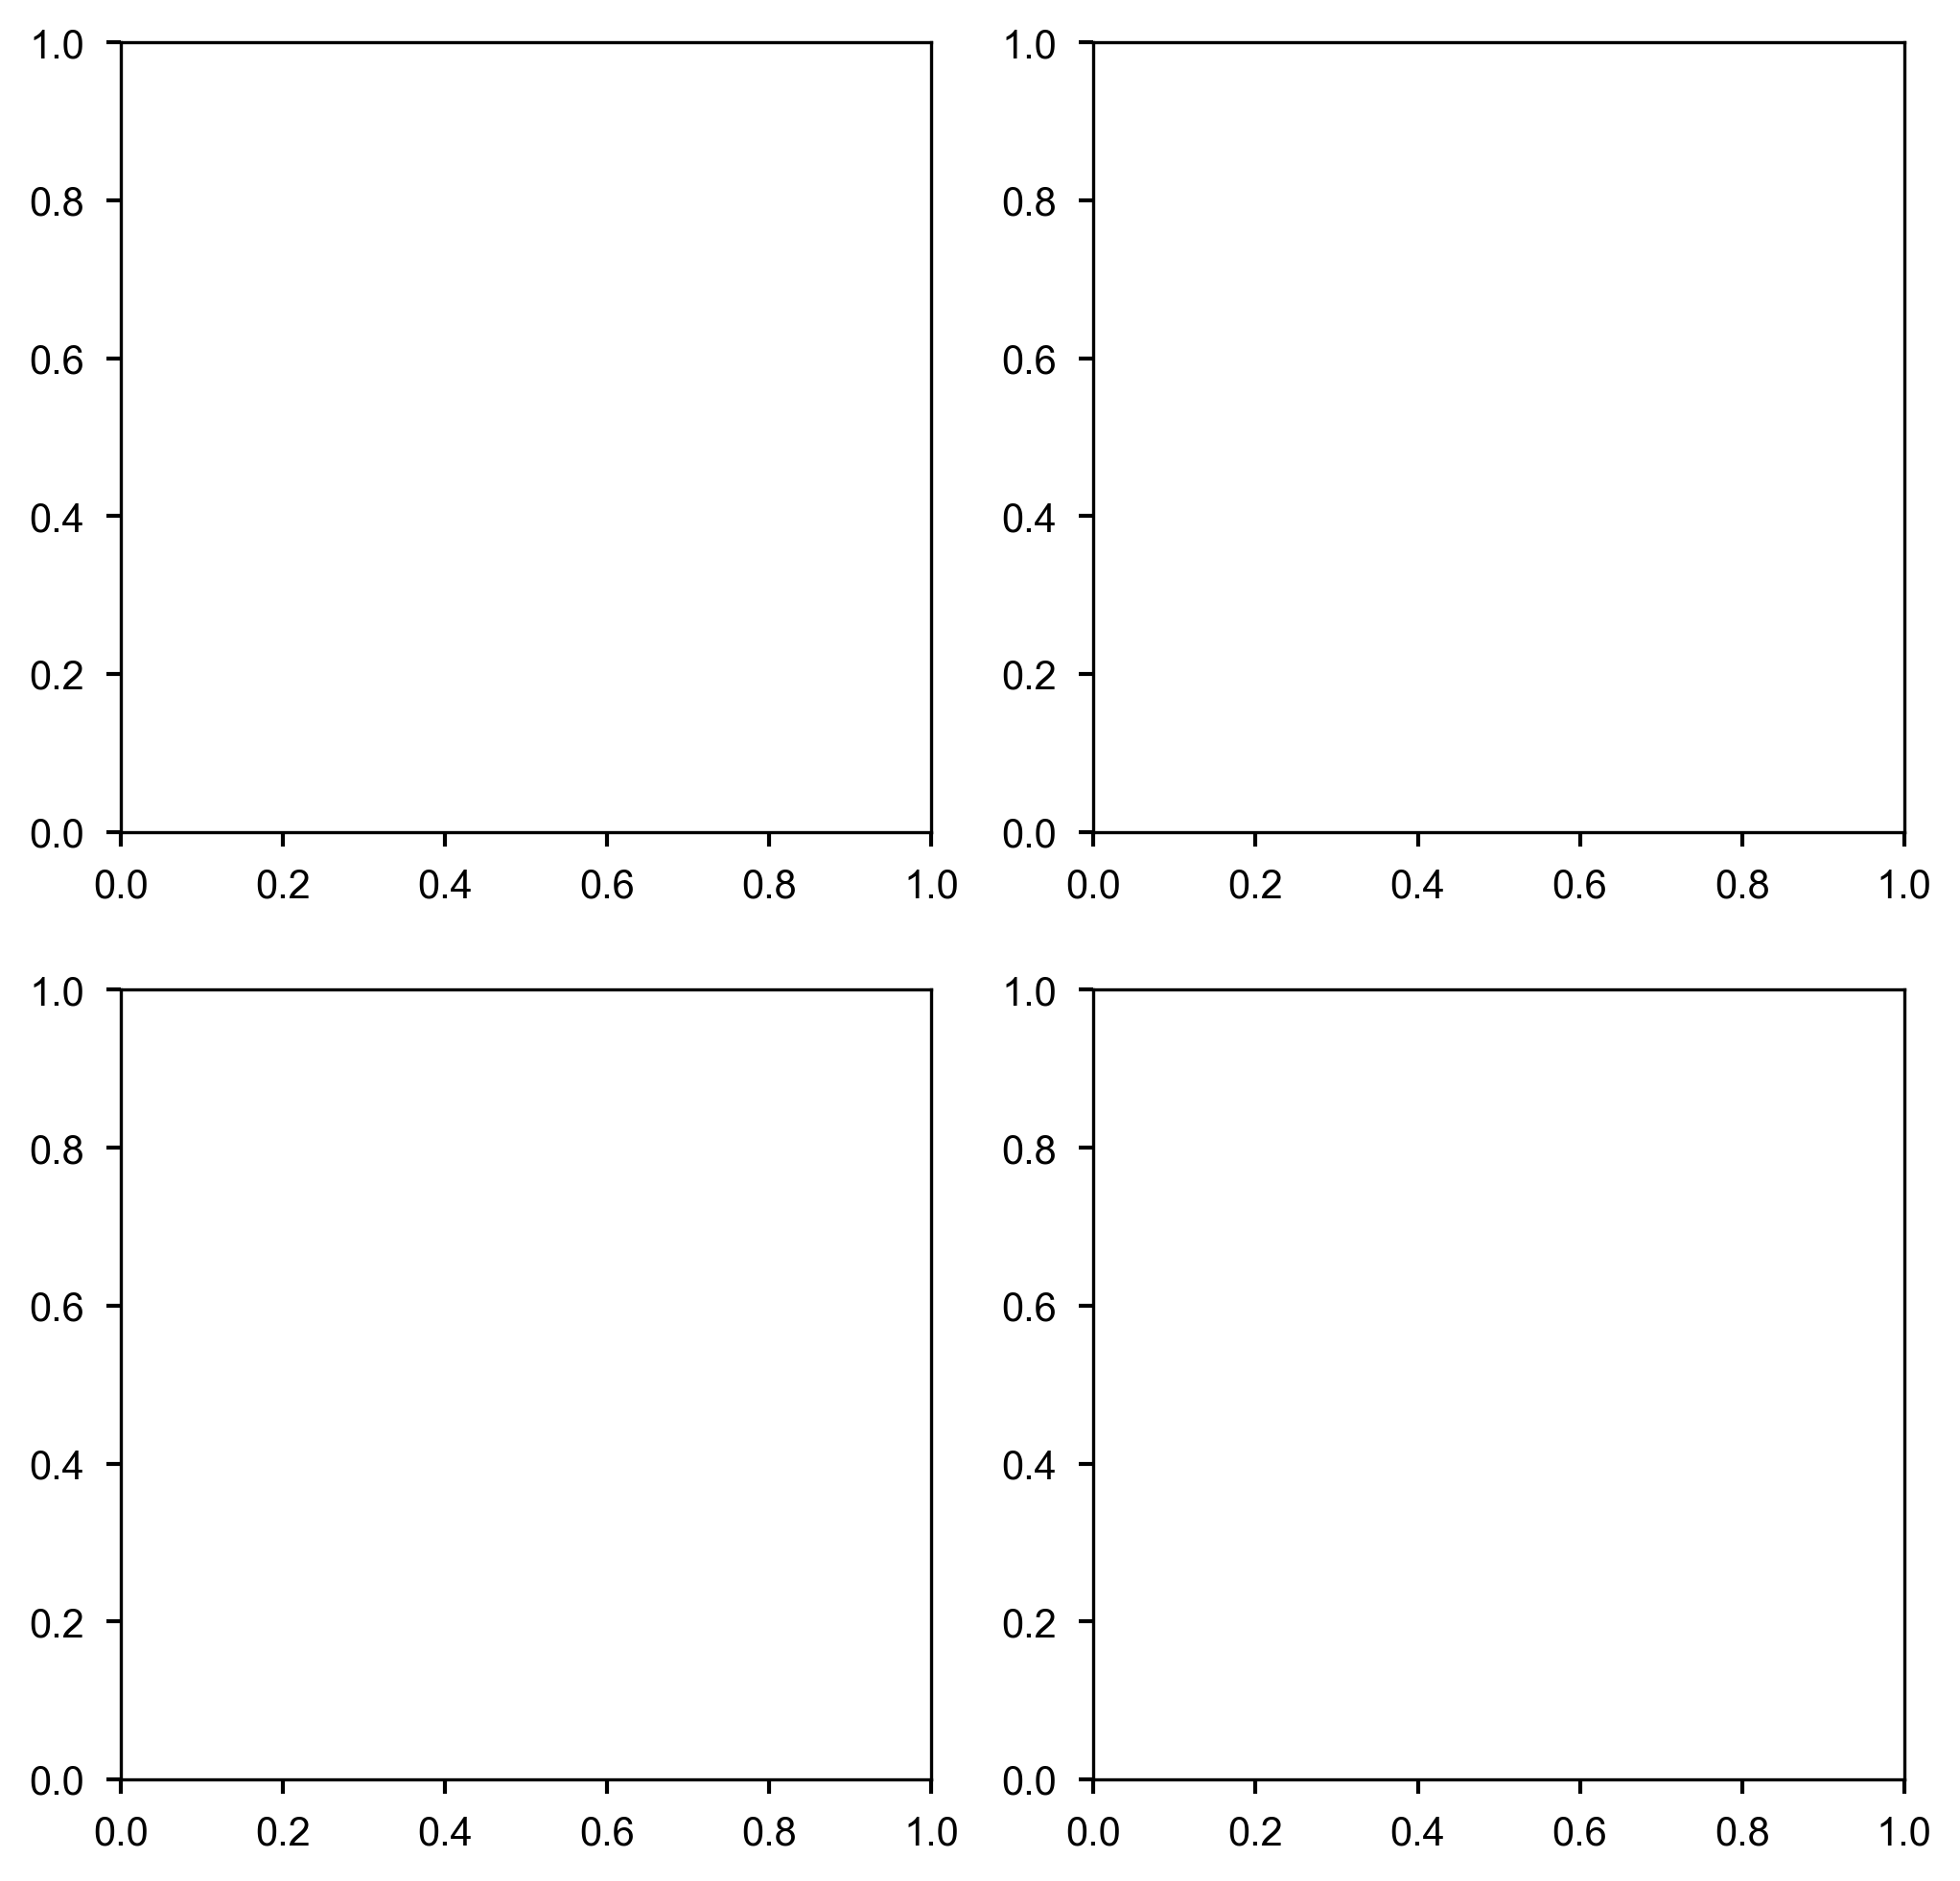

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

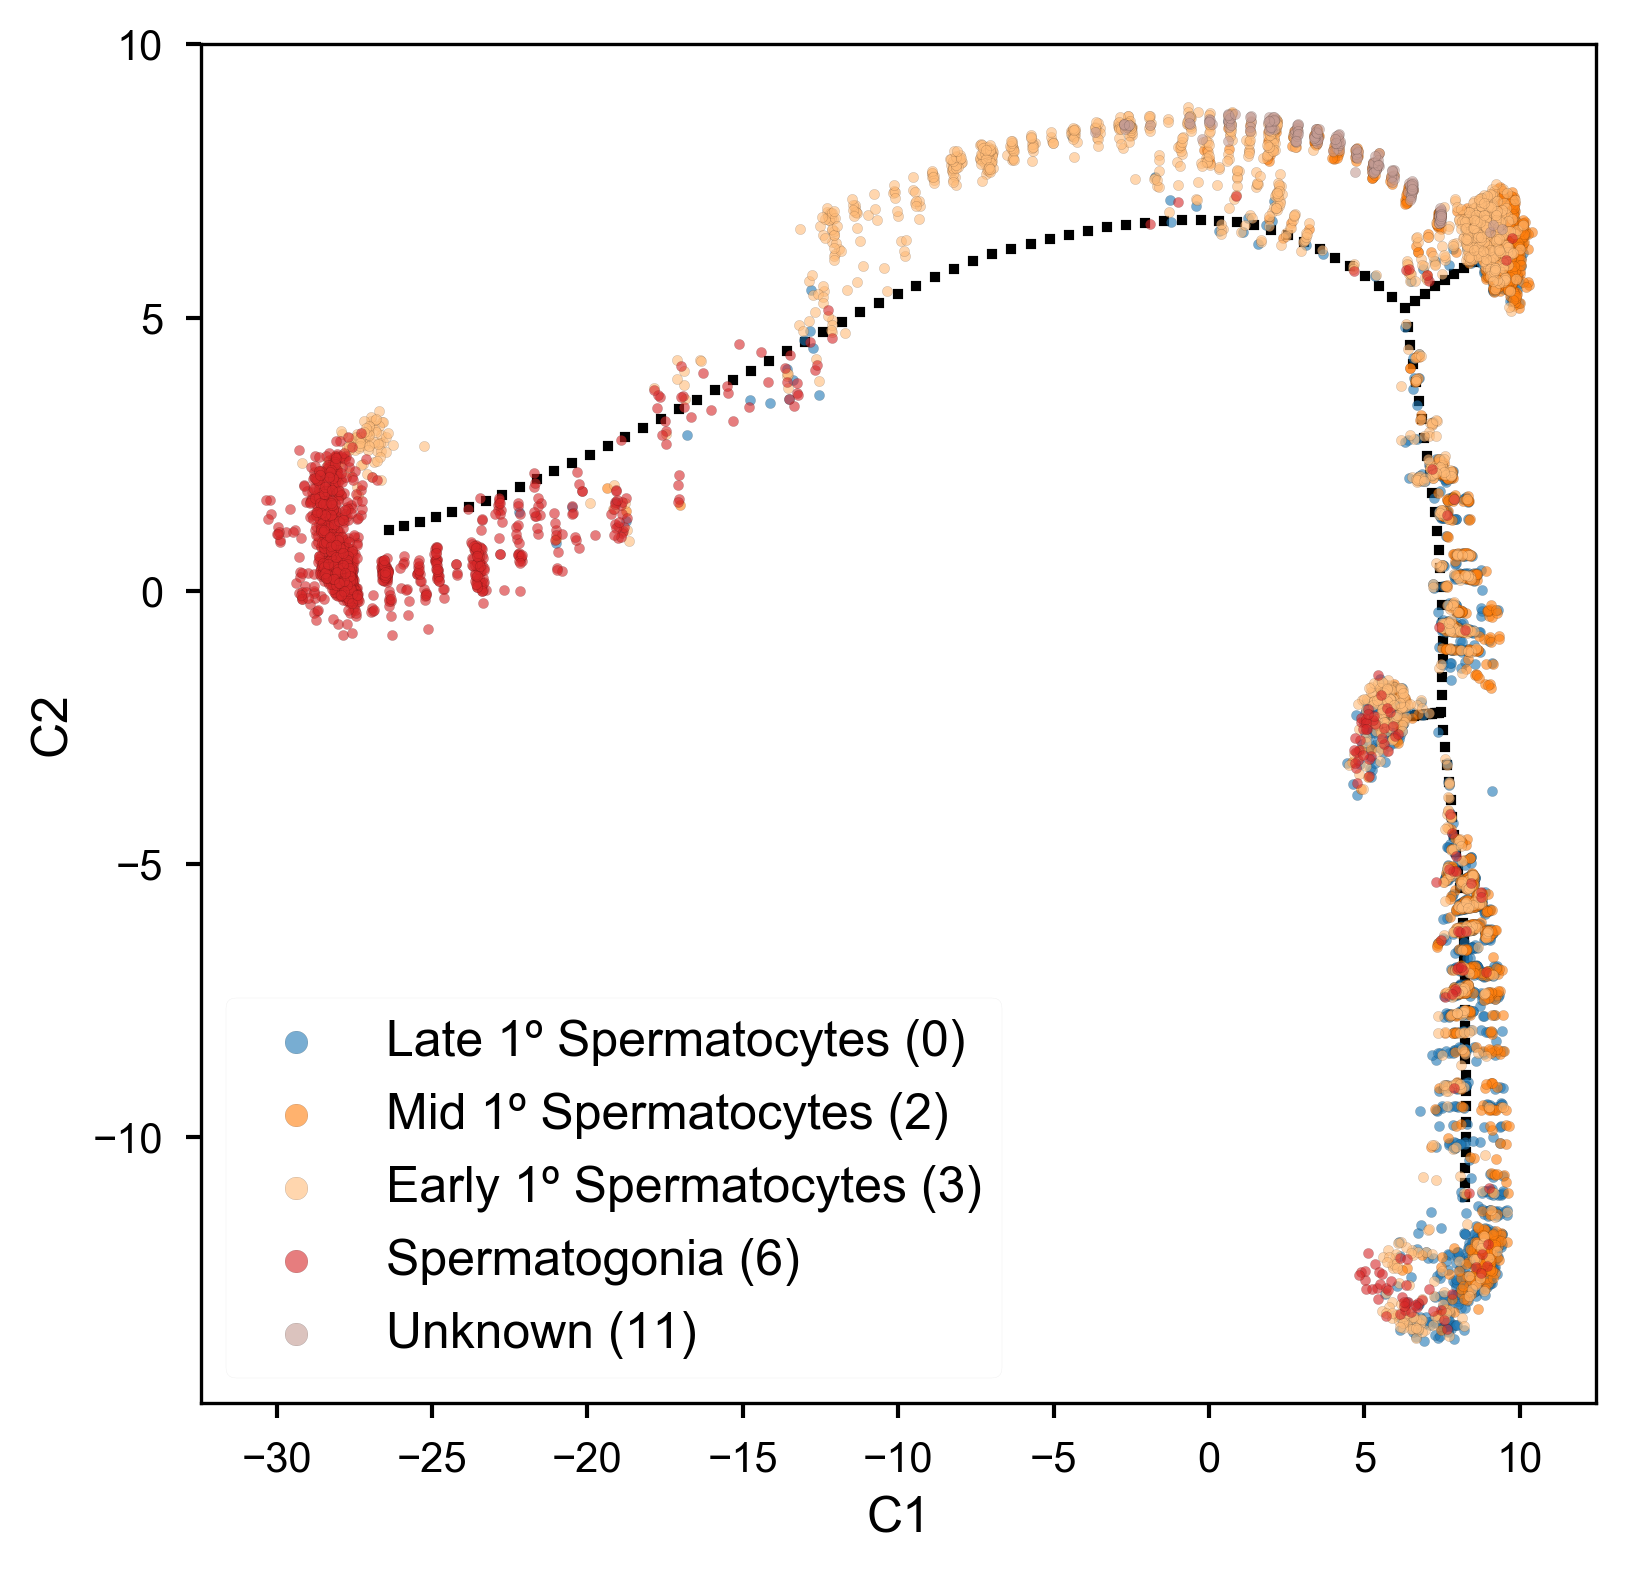

In [94]:
# Tree
fig, ax = plt.subplots()
tree = pd.read_csv('../output/pseudotime-wf/tree_location.tsv', sep='\t', index_col=0)
cells = pd.read_csv('../output/pseudotime-wf/cell_location.tsv', sep='\t', index_col=0)
cells = cells.join(nbconfig.seurat.get_clusters('res.0.6'))

tree.plot('C1', 'C2', kind='scatter', marker='s', s=5, color='k', ax=ax)
for clus, dd in cells.groupby('cluster'):
    cname = nbconfig.CLUSTER_ANNOT[clus]
    dd.plot('C1', 'C2', kind='scatter', ax=ax, s=6, alpha=0.6, edgecolor='k', color=cmapper[cname], label=cname)
    
lg = plt.legend()
for h in lg.legendHandles:
    h._sizes = [30]
    h._alpha = .9

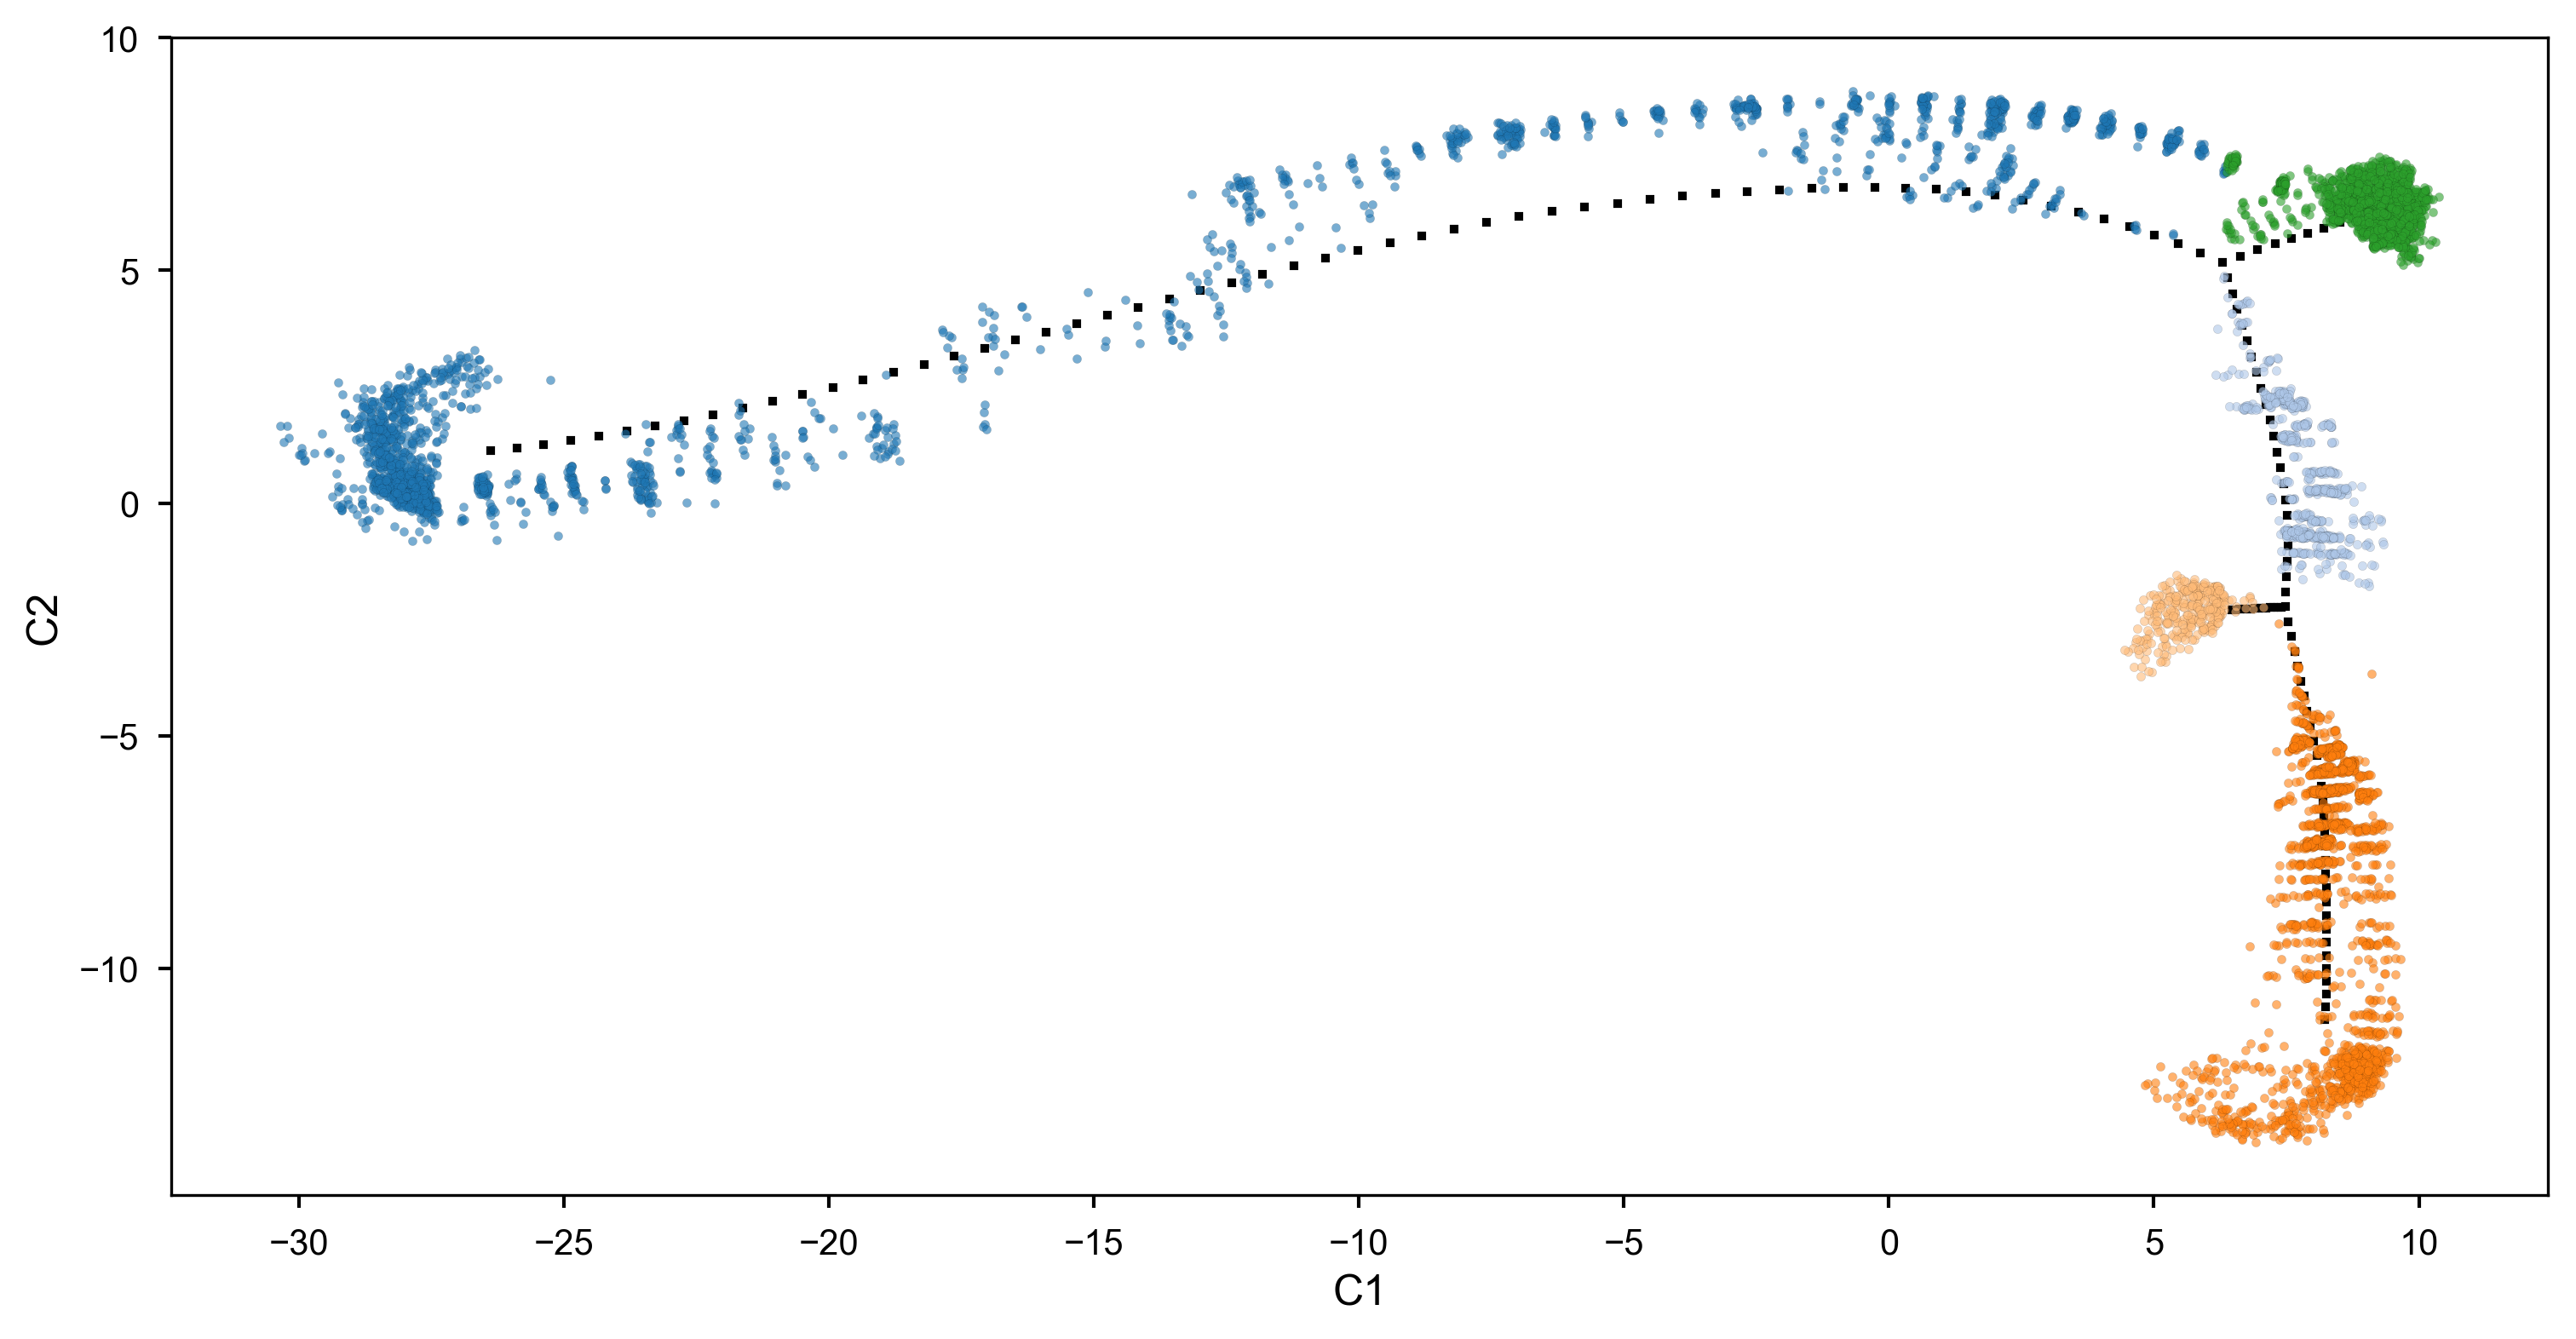

In [28]:
# Tree
fig, ax = plt.subplots(figsize=plt.figaspect(1/2))
tree = pd.read_csv('../output/pseudotime-wf/tree_location.tsv', sep='\t', index_col=0)
cells = pd.read_csv('../output/pseudotime-wf/cell_location.tsv', sep='\t', index_col=0)
metadata = pd.read_csv('../output/pseudotime-wf/pseudotime.tsv', sep='\t', index_col=0)['State']
cells = cells.join(metadata)
tree.plot('C1', 'C2', kind='scatter', marker='s', s=5, color='k', ax=ax)
colors = sns.color_palette('tab20', n_colors=5)
for color, (clus, dd) in zip(colors, cells.groupby('State')):
    dd.plot('C1', 'C2', kind='scatter', ax=ax, s=6, alpha=0.6, edgecolor='k', c=color)

1

In [175]:
pseudotime = pd.read_csv('../output/pseudotime-wf/pseudotime.tsv', sep='\t', index_col=0)

clusters = nbconfig.seurat.get_clusters('res.0.6')
germcells = clusters[clusters.isin([0, 2, 3, 6, 11])].index.tolist()

#clusters = pseudotime['State'].copy()
#clusters.name = 'cluster'
#germcells = clusters.index.tolist()

In [176]:
normX = nbconfig.seurat.get_normalized_read_counts().join(nbconfig.fbgn2chrom).query('chrom == "chrX"').drop('chrom', axis=1)
normXGerm = normX.reindex(germcells, axis=1)
normXGermOn = normXGerm[~(normXGerm == 0).all(axis=1)].sum()

xtraj = pd.concat([normXGermOn, pseudotime['Pseudotime']], axis=1).join(clusters)
xtraj.sort_values('Pseudotime', inplace=True)
xtraj.rename({0: 'Total X Expression'}, axis=1, inplace=True)

(0, 1000)

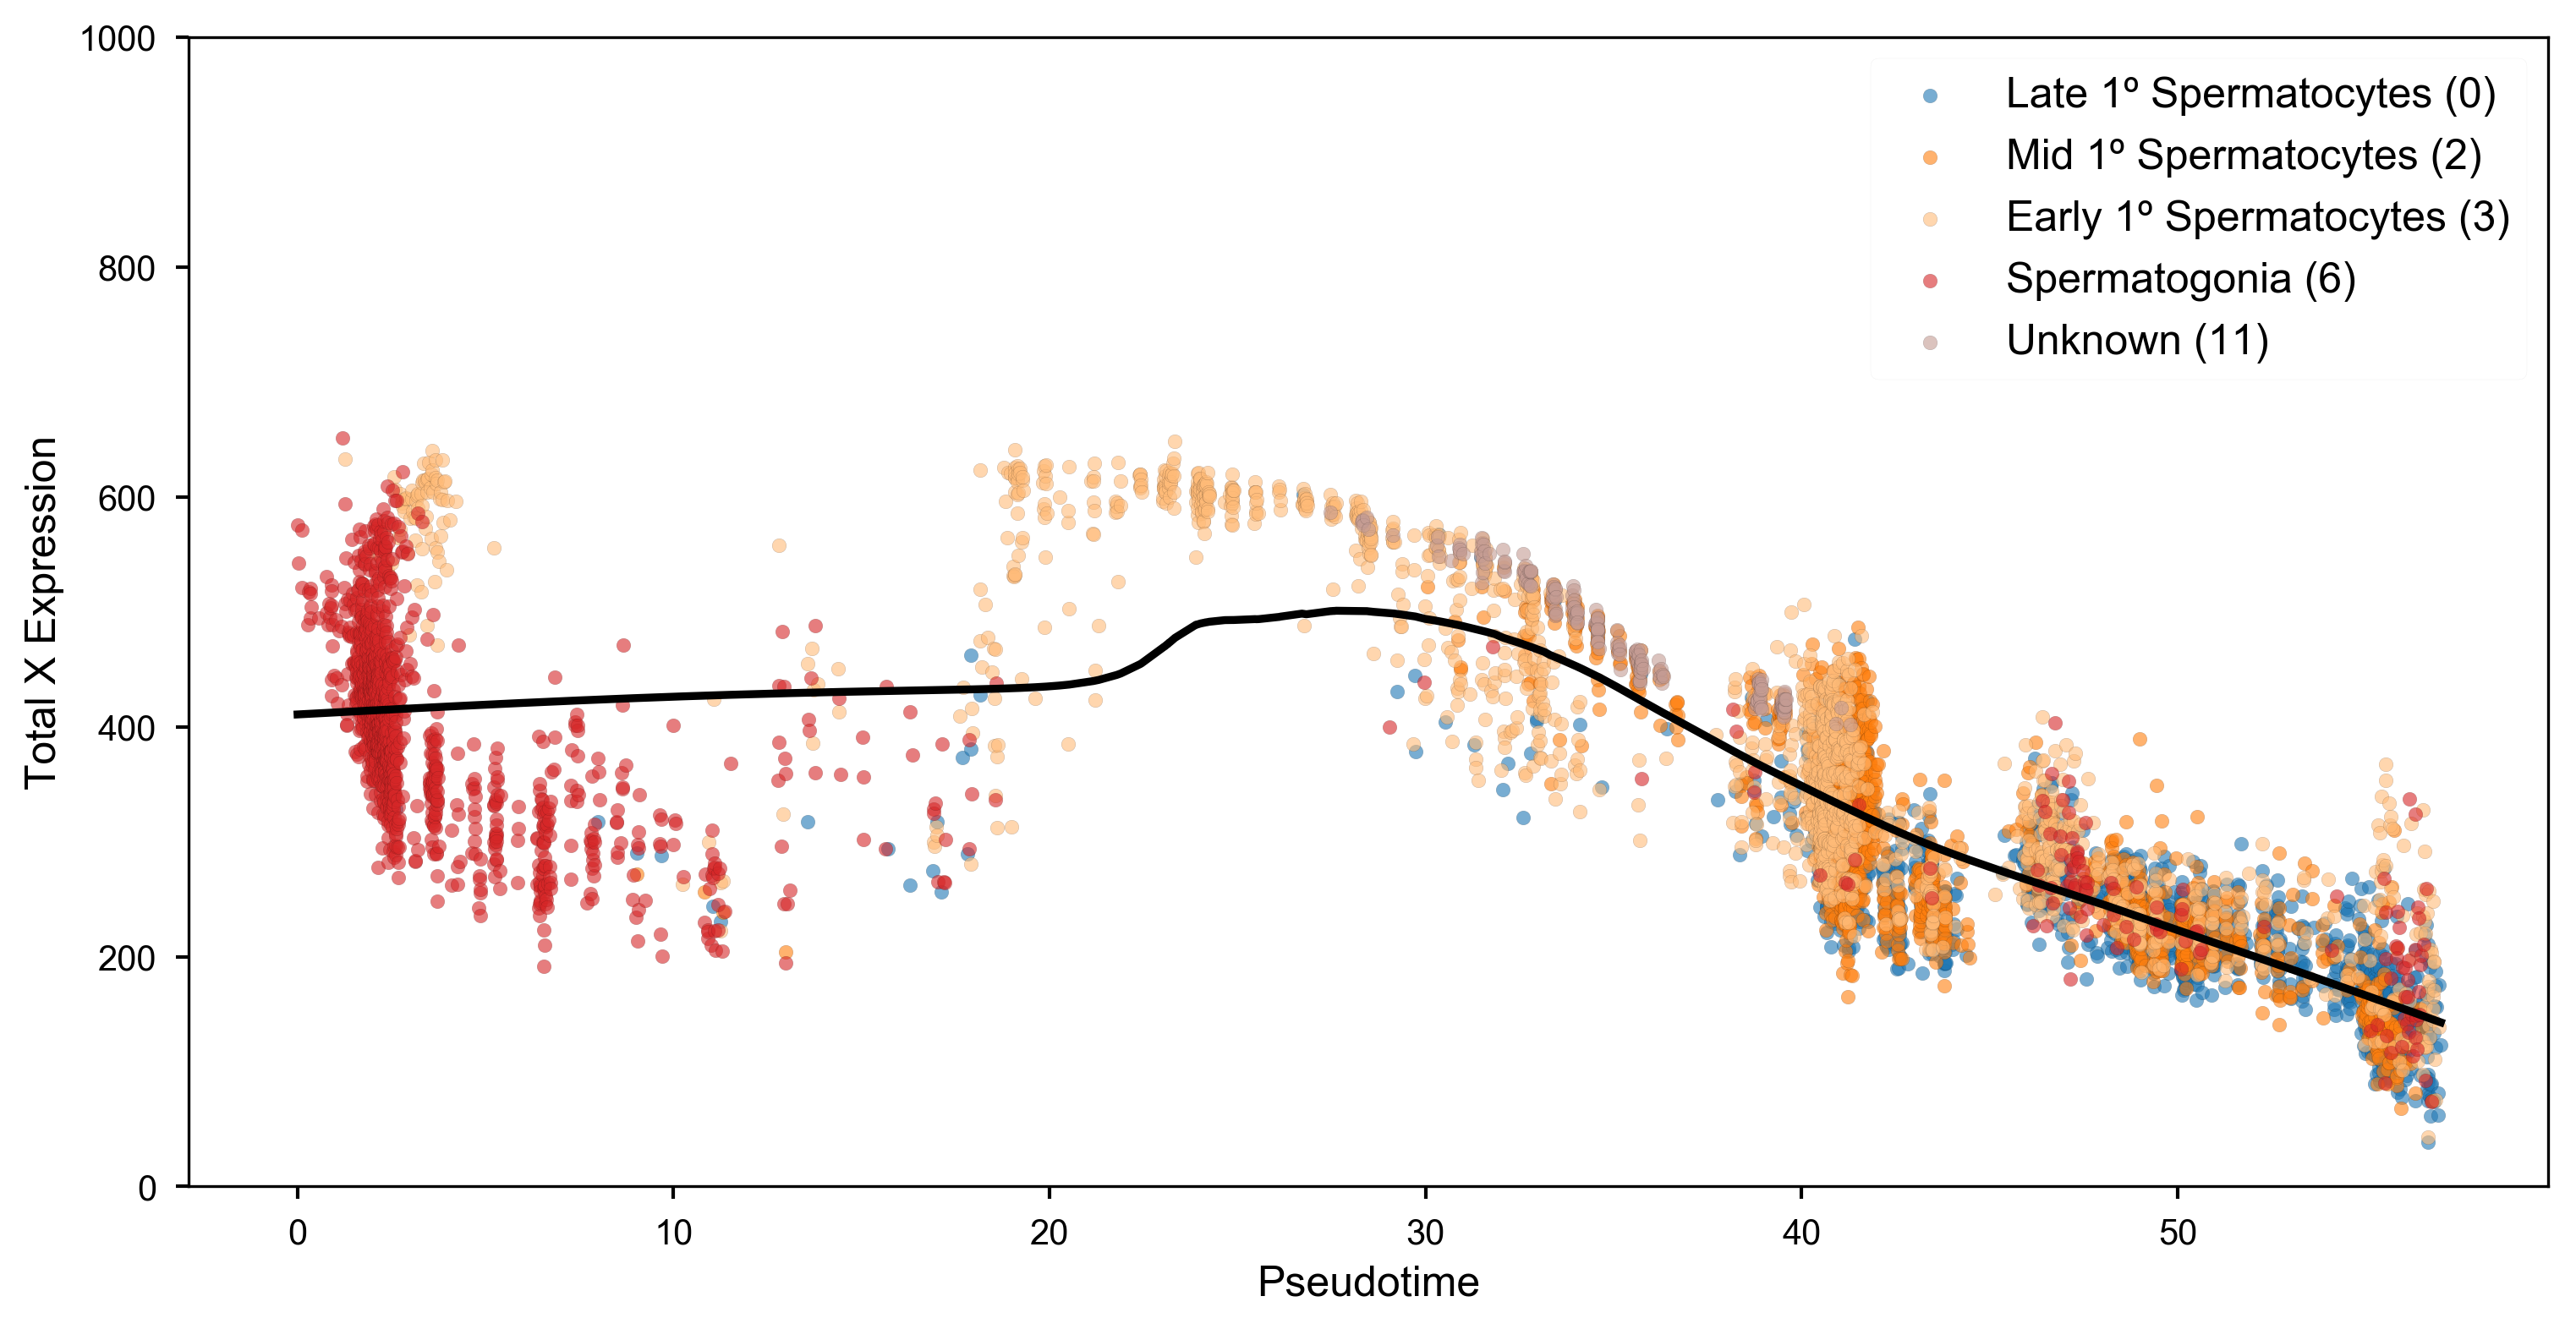

In [192]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/2))
for clus, dd in xtraj.groupby('cluster'):
    cname = nbconfig.CLUSTER_ANNOT[clus]
    dd.plot('Pseudotime', 'Total X Expression', kind='scatter', color=cmapper[cname], label=cname, ax=ax, s=16, alpha=.6, edgecolor='k')
    
sns.regplot('Pseudotime', 'Total X Expression', data=xtraj, lowess=True, scatter_kws={'s': 0}, ax=ax, line_kws={'color': 'k'})
ax.set_ylim(0, 1000)

In [178]:
norm2L = nbconfig.seurat.get_normalized_read_counts().join(nbconfig.fbgn2chrom).query('chrom == "chr2L"').drop('chrom', axis=1)
norm2LGerm = norm2L.reindex(germcells, axis=1)
norm2LGermOn = norm2LGerm[~(norm2LGerm == 0).all(axis=1)].sum()

TwoLtraj = pd.concat([norm2LGermOn, pseudotime['Pseudotime']], axis=1).join(clusters)
TwoLtraj.sort_values('Pseudotime', inplace=True)
TwoLtraj.rename({0: 'Total 2L Expression'}, axis=1, inplace=True)

(0, 1000)

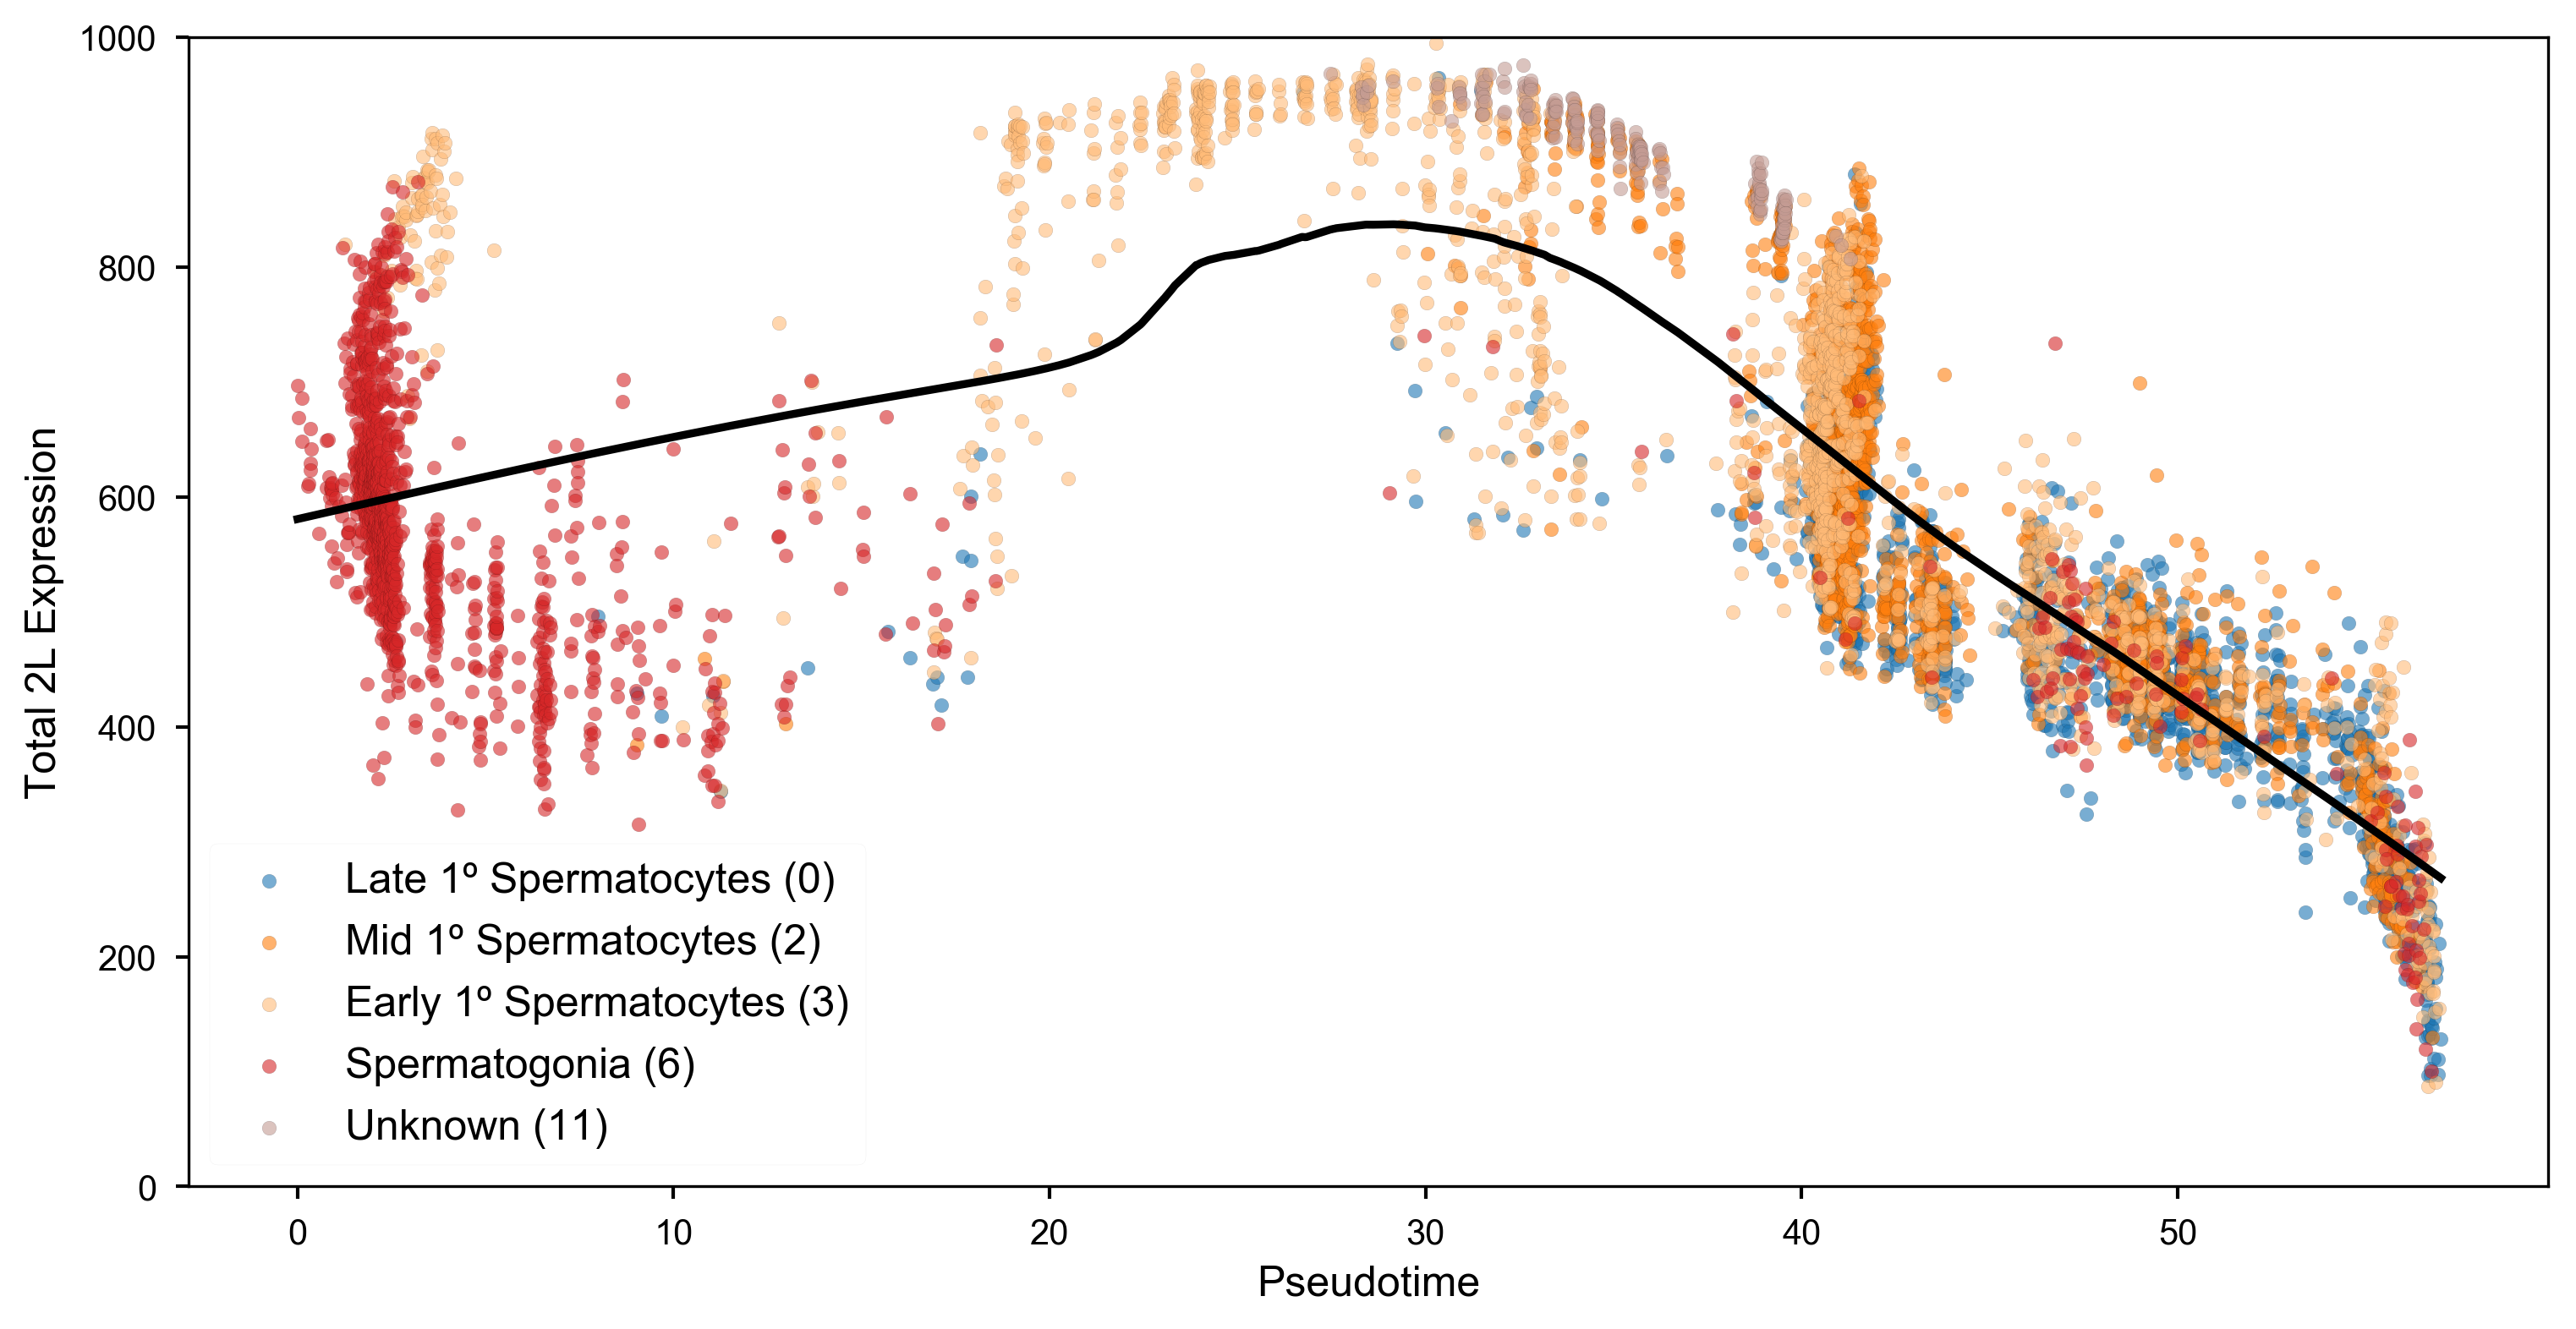

In [189]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/2))
for clus, dd in TwoLtraj.groupby('cluster'):
    cname = nbconfig.CLUSTER_ANNOT[clus]
    dd.plot('Pseudotime', 'Total 2L Expression', kind='scatter', color=cmapper[cname], label=cname, ax=ax, s=16, alpha=.6, edgecolor='k')
sns.regplot('Pseudotime', 'Total 2L Expression', data=TwoLtraj, lowess=True, scatter_kws={'s': 0}, ax=ax, line_kws={'color': 'k'})

ax.set_ylim(0, 1000)